## Install TensorTrade

In [1]:
!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git

  Cloning https://github.com/tensortrade-org/tensortrade.git to /tmp/pip-req-build-9bm7xts0
  Running command git clone --filter=blob:none --quiet https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-9bm7xts0
  Resolved https://github.com/tensortrade-org/tensortrade.git to commit bdc83c0ded7281f835ef5cb5bc8f57694bb28e87
  Preparing metadata (setup.py) ... done


## Define global variables

In [2]:
n_steps = 1000
n_episodes = 20
window_size = 30
memory_capacity = n_steps * 10
save_path = 'agents/'
n_bins = 5             # Number of bins to partition the dataset evenly in order to evaluate class sparsity.
seed = 1337

## Setup Data Fetching

In [3]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [4]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.000000,8714.900000,8739.000000,8988053
1,2018-05-15 07:00 AM,8739.0,8754.800000,8719.300000,8743.000000,2288904
2,2018-05-15 08:00 AM,8743.0,8743.100000,8653.200000,8723.700000,8891773
3,2018-05-15 09:00 AM,8723.7,8737.800000,8701.200000,8708.100000,2054868
4,2018-05-15 10:00 AM,8708.1,8855.700000,8695.800000,8784.400000,17309722
...,...,...,...,...,...,...
33033,2022-02-19 08:00 PM,40000.0,40139.000000,39976.000000,40114.000000,1309665
33034,2022-02-19 09:00 PM,40110.0,40110.000000,39818.000000,39966.000000,1364890
33035,2022-02-19 10:00 PM,39966.0,40087.000000,39916.000000,40071.000000,840756
33036,2022-02-19 11:00 PM,40072.0,40179.000000,40012.000000,40128.000000,2941451


## Create features for the feed module

In [5]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

    for strategy in strategies:
        df.ta.strategy(strategy, exclude=['kvo'])

    df = df.set_index('date')

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [6]:
#data = generate_features(data)
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.000000,8714.900000,8739.000000,8988053
1,2018-05-15 07:00 AM,8739.0,8754.800000,8719.300000,8743.000000,2288904
2,2018-05-15 08:00 AM,8743.0,8743.100000,8653.200000,8723.700000,8891773
3,2018-05-15 09:00 AM,8723.7,8737.800000,8701.200000,8708.100000,2054868
4,2018-05-15 10:00 AM,8708.1,8855.700000,8695.800000,8784.400000,17309722
...,...,...,...,...,...,...
33033,2022-02-19 08:00 PM,40000.0,40139.000000,39976.000000,40114.000000,1309665
33034,2022-02-19 09:00 PM,40110.0,40110.000000,39818.000000,39966.000000,1364890
33035,2022-02-19 10:00 PM,39966.0,40087.000000,39916.000000,40071.000000,840756
33036,2022-02-19 11:00 PM,40072.0,40179.000000,40012.000000,40128.000000,2941451


## Remove features with low variance before splitting the dataset

In [7]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.000000,8714.900000,8739.000000,8988053
1,2018-05-15 07:00 AM,8739.0,8754.800000,8719.300000,8743.000000,2288904
2,2018-05-15 08:00 AM,8743.0,8743.100000,8653.200000,8723.700000,8891773
3,2018-05-15 09:00 AM,8723.7,8737.800000,8701.200000,8708.100000,2054868
4,2018-05-15 10:00 AM,8708.1,8855.700000,8695.800000,8784.400000,17309722
...,...,...,...,...,...,...
33033,2022-02-19 08:00 PM,40000.0,40139.000000,39976.000000,40114.000000,1309665
33034,2022-02-19 09:00 PM,40110.0,40110.000000,39818.000000,39966.000000,1364890
33035,2022-02-19 10:00 PM,39966.0,40087.000000,39916.000000,40071.000000,840756
33036,2022-02-19 11:00 PM,40072.0,40179.000000,40012.000000,40128.000000,2941451


## Split dataset

In [8]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [9]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

## Get dataset statistics

In [10]:
from scipy.stats import iqr

def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0

def is_sparse(data, column='close'):
    binary_gains = precalculate_ground_truths(data, column=column)
    bins = [n * (binary_gains.shape[0] // n_bins) for n in range(n_bins)]
    bins += [binary_gains.shape[0]]
    bins = [binary_gains.iloc[bins[n]:bins[n + 1]] for n in range(n_bins)]
    return all([bin.astype(bool).any() for bin in bins])

def is_data_predictible(data, column):
    return not is_null(data) & is_sparse(data, column)

data.describe(include='all')

,date,open,high,low,close,volume
count,33038,33038.000000,33038.000000,33038.000000,33038.000000,3.303800e+04
unique,33037,NaN,NaN,NaN,NaN,NaN
top,2020-11-10 11:00 PM,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN
mean,NaN,20018.019596,20125.900952,19902.725127,20019.004573,7.589617e+06
std,NaN,18516.489851,18622.846826,18402.642568,18516.776394,1.465729e+07
min,NaN,3229.800000,3247.100000,3215.200000,3229.800000,0.000000e+00
25%,NaN,6989.725000,7025.300000,6950.025000,6989.725000,1.205956e+06
50%,NaN,9673.700000,9708.020000,9635.200000,9673.985000,3.203713e+06
75%,NaN,36022.744350,36302.000000,35711.000000,36022.500000,8.255541e+06


## Evaluate outlier sparsity of the data

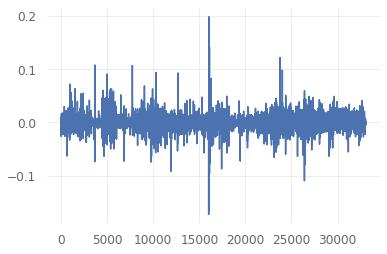

True

In [11]:
import matplotlib.pyplot as plt
plt.plot(get_returns(data, column='close'))
plt.show()
is_data_predictible(data, 'close')

## Percentage of the dataset generating rewards (keep between 5% to 15% or just rely on is_data_predictible())

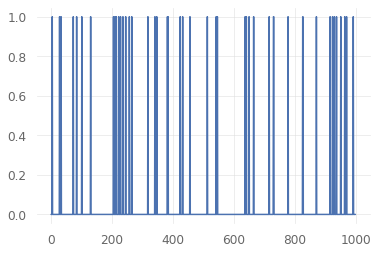

8.18%


In [12]:
plt.plot(precalculate_ground_truths(data, column='close').iloc[:1000])
plt.show()
percent_rewardable = str(round(100 + precalculate_ground_truths(data, column='close').value_counts().pct_change().iloc[-1] * 100, 2)) + '%'
print(percent_rewardable)

## Threshold to pass to AnomalousProfit reward scheme

In [13]:
X_train_test = pd.concat([X_train, X_test], axis='index')
#threshold = estimate_percent_gains(X_train_test, 'close')
threshold = estimate_percent_gains(X_train, 'close')
threshold

0.007156155327167596

## Implement basic feature engineering

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [15]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=seed, 
                            n_jobs=6)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.5)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))

SelectBySingleFeaturePerformance(cv=5,
                                 estimator=RandomForestClassifier(n_jobs=6,
                                                                  random_state=1337),
                                 threshold=0.5)

In [16]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)
feature_performance

volume    0.659456
close     0.441434
open      0.437235
high      0.432563
low       0.412375
dtype: float64

Text(0, 0.5, 'roc-auc')

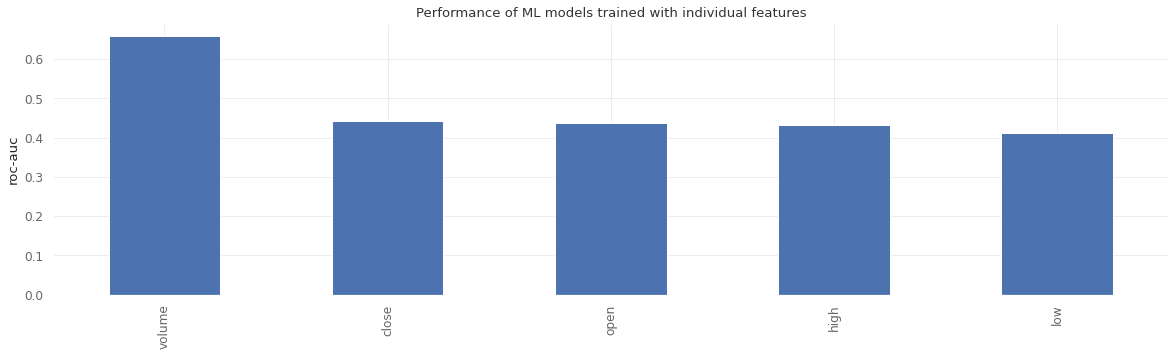

In [17]:
feature_performance.plot.bar(figsize=(20, 5))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

In [18]:
features_to_drop = sel.features_to_drop_
features_to_drop

['open', 'high', 'low', 'close']

In [19]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

0

In [20]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

((11067, 6), (11068, 6), (10903, 6))

In [21]:
X_train.columns.tolist()

['date', 'open', 'high', 'low', 'close', 'volume']

## Normalize the dataset subsets to make the model converge faster

In [22]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [23]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

## Write a reward scheme encouraging rare volatile upside trades

In [24]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme


class AnomalousProfit(TensorTradeRewardScheme):
    """A simple reward scheme that rewards the agent for exceeding a 
    precalculated percentage in the net worth.

    Parameters
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.

    Attributes
    ----------
    threshold : float
        The minimum value to exceed in order to get the reward.
    """

    registered_name = "anomalous"

    def __init__(self, threshold: float = 0.02, window_size: int = 1):
        self._window_size = self.default('window_size', window_size)
        self._threshold = self.default('threshold', threshold)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for incremental increases in net worth over a
        sliding window.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            Whether the last percent change in net worth exceeds the predefined 
            `threshold`.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            # Hint: make it cumulative.
            net_worths = performance['net_worth']
            ground_truths = precalculate_ground_truths(performance, 
                                                       column='net_worth', 
                                                       threshold=self._threshold)
            reward_factor = 2.0 * ground_truths - 1.0
            #return net_worths.iloc[-1] / net_worths.iloc[-min(current_step, self._window_size + 1)] - 1.0
            return (reward_factor * net_worths.abs()).iloc[-1]

        else:
            return 0.0

In [25]:
class PenalizedProfit(TensorTradeRewardScheme):
    """A reward scheme which penalizes net worth loss and 
    decays with the time spent.

    Parameters
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion

    Attributes
    ----------
    cash_penalty_proportion : float
        cash_penalty_proportion.
    """

    registered_name = "penalized"

    def __init__(self, cash_penalty_proportion: float = 0.10):
        self._cash_penalty_proportion = \
            self.default('cash_penalty_proportion', 
                         cash_penalty_proportion)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for gaining net worth while holding the asset.

        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.

        Returns
        -------
        int
            A penalized reward.
        """
        performance = pd.DataFrame.from_dict(portfolio.performance).T
        current_step = performance.shape[0]
        if current_step > 1:
            initial_amount = portfolio.initial_net_worth
            net_worth = performance['net_worth'].iloc[-1]
            cash_worth = performance['bitstamp:/USD:/total'].iloc[-1]
            cash_penalty = max(0, (net_worth * self._cash_penalty_proportion - cash_worth))
            net_worth -= cash_penalty
            reward = (net_worth / initial_amount) - 1
            reward /= current_step
            return reward
        else:
            return 0.0

## TODO: implement tuning

## Setup Trading Environment

In [26]:
import tensortrade.env.default as default

#from tensortrade.agents import DQNAgent
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

# TODO: adjust according to your commission percentage, if present
commission = 0.001
price = Stream.source(list(X_train["close"]), 
                      dtype="float").rename("USD-BTC")
#bitstamp_options = ExchangeOptions(commission=commission)
#bitstamp = Exchange("bitstamp", 
#                    service=execute_order, 
#                    options=bitstamp_options)(price)
bitstamp = Exchange("bitstamp", 
                    service=execute_order)(price)

cash = Wallet(bitstamp, 50000 * USD)
asset = Wallet(bitstamp, 0 * BTC)

portfolio = Portfolio(USD, [cash, asset])

with NameSpace("bitstamp"):
    features = [
        Stream.source(list(X_train_scaled[c]), 
                      dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        #Stream.source(list(X_train_scaled['lr_close']), dtype="float").rename('lr_close')
    ]

feed = DataFeed(features)
feed.compile()

renderer_feed = DataFeed([
    Stream.source(list(X_train["date"])).rename("date"),
    Stream.source(list(X_train["open"]), dtype="float").rename("open"),
    Stream.source(list(X_train["high"]), dtype="float").rename("high"),
    Stream.source(list(X_train["low"]), dtype="float").rename("low"),
    Stream.source(list(X_train["close"]), dtype="float").rename("close"), 
    Stream.source(list(X_train["volume"]), dtype="float").rename("volume") 
])

action_scheme = BSH(
    cash=cash,
    asset=asset
)

#reward_scheme = RiskAdjustedReturns(return_algorithm='sortino',
#                                    window_size=30)

#reward_scheme = SimpleProfit(window_size=30)

reward_scheme = AnomalousProfit(threshold=threshold)

#reward_scheme = PenalizedProfit(cash_penalty_proportion=0.1)

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=30
)

In [27]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 8739.0,
  'bitstamp:/USD:/free': 50000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 50000.0,
  'bitstamp:/BTC:/free': 0.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 0.0,
  'bitstamp:/BTC:/worth': 0.0,
  'net_worth': 50000.0},
 'external': {'bitstamp:/open': 0.35165651083004756,
  'bitstamp:/high': 0.35328929347237537,
  'bitstamp:/low': 0.3538422935378439,
  'bitstamp:/close': 0.3525617232596536,
  'bitstamp:/volume': 0.0604746164979527},
 'renderer': {'date': '2018-05-15 06:00 AM',
  'open': 8723.8,
  'high': 8793.0,
  'low': 8714.9,
  'close': 8739.0,
  'volume': 8988053}}

## Setup and Train DQN Agent

In [28]:
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size(window_size=window_size, n_steps=n_steps, batch_factor=4)
batch_size

242

## Implement validation here

## Print basic quantstats report

In [29]:
def print_quantstats_full_report(env, data, output='dqn_quantstats'):
    performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
    net_worth = performance['net_worth'].iloc[window_size:]
    returns = net_worth.pct_change().iloc[1:]

    # WARNING! The dates are fake and default parameters are used!
    returns.index = pd.date_range(start=data['date'].iloc[0], freq='1d', periods=returns.size)

    qs.reports.full(returns)
    qs.reports.html(returns, output=output + '.html')

#print_quantstats_full_report(env, data)

In [30]:
max_allowed_loss = 0.90
min_periods = window_size  # Minimum of window_size

observer = default.observers.TensorTradeObserver(
    portfolio=portfolio,
    feed=feed,
    renderer_feed=renderer_feed,
    window_size=window_size,
    min_periods=min_periods
)

stopper = default.stoppers.MaxLossStopper(
    max_allowed_loss=max_allowed_loss
)

informer = default.informers.TensorTradeInformer()

renderer = default.renderers.PlotlyTradingChart()

random_start_pct = 0.0

In [31]:
env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    observer=observer,
    stopper=stopper,
    informer=informer,
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=renderer,
    min_periods=min_periods,
    random_start_pct=random_start_pct,
    window_size=30
)

In [32]:
'''
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward
'''

'\ndef evaluate(model, num_episodes=100):\n    """\n    Evaluate a RL agent\n    :param model: (BaseRLModel object) the RL Agent\n    :param num_episodes: (int) number of episodes to evaluate it\n    :return: (float) Mean reward for the last num_episodes\n    """\n    # This function will only work for a single Environment\n    env = model.get_env()\n    all_episode_rewards = []\n    for i in range(num_episodes):\n        episode_rewards = []\n        done = False\n        obs = env.reset()\n        while not done:\n            # _states are only useful when using LSTM policies\n            action, _states = model.predict(obs)\n            # here, action, rewards and dones are arrays\n            # because we are using vectorized env\n            obs, reward, done, info = env.step(action)\n            episode_rewards.append(reward)\n\n        all_episode_rewards.append(sum(episode_rewards))\n\n    mean_episode_reward = np.mean(all_episode_rewards)\n    print("Mean reward:", mean_episod

In [33]:
def evaluate(model, 
             env=None, 
             n_eval_episodes=1, 
             n_eval_steps=100, 
             render_episode_count=1, 
             render_step_count=10, 
             render_episodes=False, 
             render_steps=True):
    """
    Evaluate a RL agent, with rendering
    :param model: (BaseRLModel object) the RL Agent
    :param n_eval_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last n_eval_episodes
    """
    if env is None:
        env = model.get_env()

    render_episode_interval = n_eval_episodes // render_episode_count
    render_step_interval = n_eval_steps // render_step_count

    all_episode_rewards = []
    for i in range(n_eval_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        if n_eval_steps < 1:
            while not done:
                # _states are only useful when using LSTM policies
                action, _states = model.predict(obs, deterministic=True)
                # here, action, rewards and dones are arrays
                # because we are using vectorized env
                obs, reward, done, info = env.step(action)
                episode_rewards.append(reward)
                if render_steps and (i % render_step_interval) == 0:
                    env.render()
        else:
            for i in range(n_eval_steps):
                # _states are only useful when using LSTM policies
                action, _states = model.predict(obs, deterministic=True)
                # here, action, rewards and dones are arrays
                # because we are using vectorized env
                obs, reward, done, info = env.step(action)
                episode_rewards.append(reward)
                if render_steps and (i % render_step_interval) == 0:
                    env.render()

        all_episode_rewards.append(sum(episode_rewards))

        if render_episodes and (i % render_episode_interval) == 0:
            env.render()

        if done:
            obs = env.reset()

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards)
    
    print(f"Reward mean: {mean_reward:.2f} +/- {std_reward:.2f} "
          f"standard deviation for {n_eval_episodes:.2f} episodes")

    return std_episode_reward, mean_episode_reward

In [34]:
#from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.logger import configure
from stable_baselines3 import PPO

#new_logger = configure('logs', ['stdout', 'csv', 'tensorboard'])  # Setup logger

#env = Monitor(env)

model = PPO('MlpPolicy', env, verbose=1)
#model.set_logger(new_logger)  # Set new logger

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [35]:
%load_ext tensorboard

In [36]:
%tensorboard --bind_all --logdir logs

In [37]:
# Random Agent, before training
from stable_baselines3.common.evaluation import evaluate_policy

#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)

#print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In [38]:
# Train the agent for 10000 steps
model.learn(total_timesteps=200)

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.58e+03  |
|    ep_rew_mean     | -2.76e+07 |
| time/              |           |
|    fps             | 25        |
|    iterations      | 1         |
|    time_elapsed    | 80        |
|    total_timesteps | 2048      |
----------------------------------


In [39]:
model.save("tradingenv_training")

In [40]:
#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)

#print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In [43]:
steps = 100
rendering_interval = steps // 10
obs = env.reset()
for i in range(steps):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
#    if (i % rendering_interval) == 0:
#        env.render()
#    if done:
#        obs = env.reset()

In [44]:
env.render()

FigureWidget({
    'data': [{'close': array([8348.6, 8158.1, 8205.9, ..., 7495. , 7492.9, 7519. ]),
          …